In [1]:
from hierarchy import Hierarchy
from model_loader import load_model_components
from pytt.utils import read_pickle
from processing.dataset import init_dataset
from datapoint_processor import GenericProcessor
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch
from matplotlib.markers import MarkerStyle
import umap

In [2]:
hierarchy_file = 'mimic_models2/code_supervision_only_description_unfrozen/hierarchy.pkl'
val_file = '/home/jered/Documents/data/mimic-iii-clinical-database-1.4/preprocessed/reports_and_codes_expanded/val.data'
limit_rows = 10
val_dataset = init_dataset(val_file, limit_rows=limit_rows)
hierarchy = Hierarchy.from_dict(read_pickle(hierarchy_file))
run_type = 'applications'
tsne = TSNE()
umap = umap.UMAP()
option_idxs = {option:i for i,option in enumerate(hierarchy.options['<start_node>'])}

models = [
    ('code_supervision_unfrozen', 'mimic_models2/code_supervision_unfrozen/model_state.tpkl'),
    ('code_supervision_only_description_unfrozen', 'mimic_models2/code_supervision_only_description_unfrozen/model_state.tpkl'),
    ('code_supervision_only_linearization_description_unfrozen', 'mimic_models2/code_supervision_only_linearization_description_unfrozen/model_state.tpkl'),
]

model_components = {}
for model_type, model_file in models:
    batcher, model, _ = load_model_components(
        model_type, hierarchy, run_type=run_type, model_file=model_file)
    model_components[model_type] = (batcher, model)

In [3]:
option_idxs

{'Trauma': 0,
 'Infection': 1,
 'Neoplasm': 2,
 'Vascular': 3,
 'Demyelinating/Autoimmune': 4,
 'Neurodegenerative': 5,
 'Metabolic and Endocrine': 6}

In [4]:
option_colors = {
    'Trauma': 'orange',
    'Infection': 'blue',
    'Neoplasm': 'green',
    'Vascular': 'red',
    'Demyelinating/Autoimmune': 'purple',
    'Neurodegenerative': 'brown',
    'Metabolic and Endocrine': 'pink',
}

In [5]:
def graph_datapoint(ax, index, model_type, num, fittype='tsne'):
    raw_datapoint = val_dataset[index]
#     context_vectors = []
#     for i,target in enumerate(raw_datapoint['targets'][:num]):
#         context_vectors.append(gps[model_type].process_datapoint(
#             raw_datapoint['reports'],
#             tag=target).results['context_vec'].view(1, -1))
#         print(i, len(raw_datapoint['targets']))
#     context_vectors = torch.cat(context_vectors, 0)
    batcher, model = model_components[model_type]
    raw_datapoint['targets'] = raw_datapoint['targets'][:num]
    batch = batcher.batch_from_raw([raw_datapoint])
    with torch.no_grad():
        context_vectors = model(**batch.get_observed())['context_vec'].squeeze(0)
    print('fitting')
    reducer = tsne if fittype == 'tsne' else umap
    transformed_context_vectors = tsne.fit_transform(context_vectors.numpy())        
    grouped_context_vectors = [{k:[] for k in option_idxs.keys()}, {k:[] for k in option_idxs.keys()}]
    for i in range(transformed_context_vectors.shape[0]):
        grouped_context_vectors[raw_datapoint['labels'][i]][hierarchy.path(raw_datapoint['targets'][i])[0]].append(
            transformed_context_vectors[i])
    for k,v in grouped_context_vectors[0].items():
        if len(v) <= 0: continue
        points = ax.scatter([c[0] for c in v], [c[1] for c in v], color=option_colors[k], marker='.')
        points.set_label('negative '+k)
    for k,v in grouped_context_vectors[1].items():
        if len(v) <= 0: continue
        points = ax.scatter([c[0] for c in v], [c[1] for c in v], color=option_colors[k], marker='^', facecolors='none', edgecolors=option_colors[k], s=200)
        points.set_label('positive '+k)

fitting
fitting
fitting


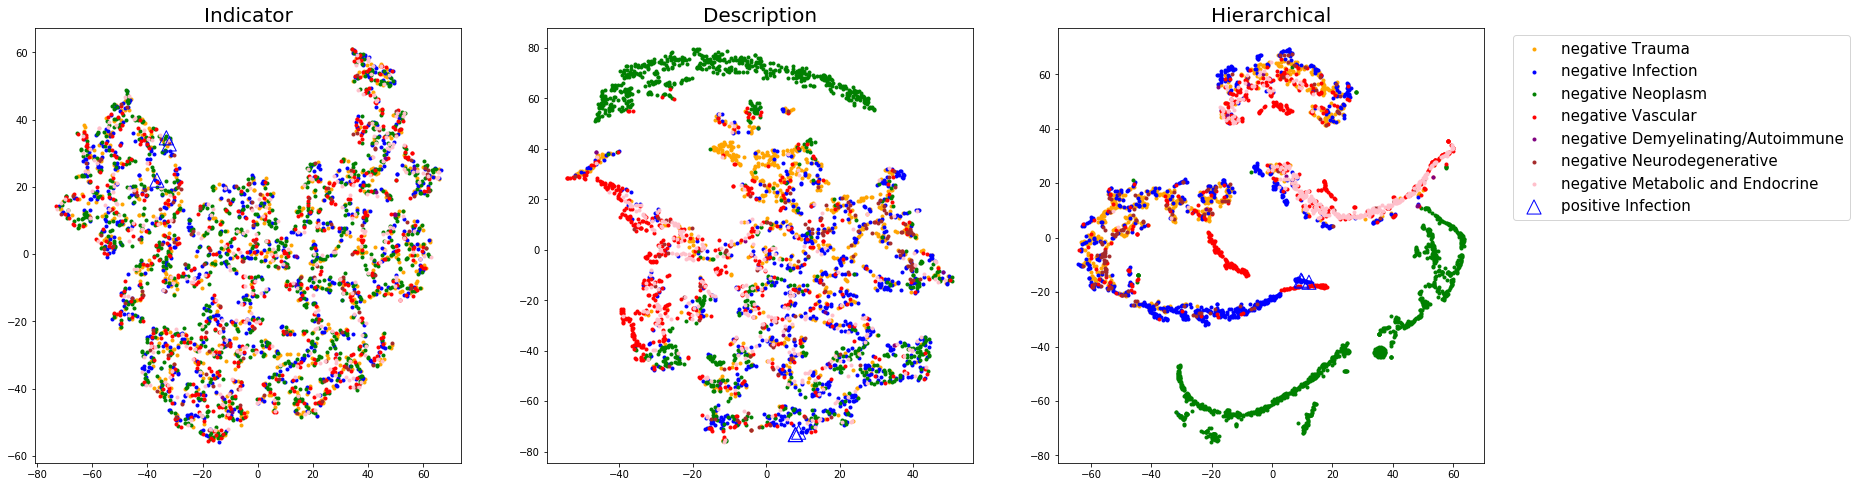

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(35, 8))
fittype = 'tsne'
ax[0].set_title('Indicator', fontsize=20)
graph_datapoint(ax[0], 2, 'code_supervision_unfrozen', 4000, fittype)
ax[1].set_title('Description', fontsize=20)
graph_datapoint(ax[1], 2, 'code_supervision_only_description_unfrozen', 4000, fittype)
ax[2].set_title('Hierarchical', fontsize=20)
graph_datapoint(ax[2], 2, 'code_supervision_only_linearization_description_unfrozen', 4000, fittype)
plt.legend(fontsize=15, bbox_to_anchor=(1.05, 1))
plt.subplots_adjust(right=0.7)
plt.savefig('context_vectors.pdf')
plt.show()

fitting
fitting
fitting


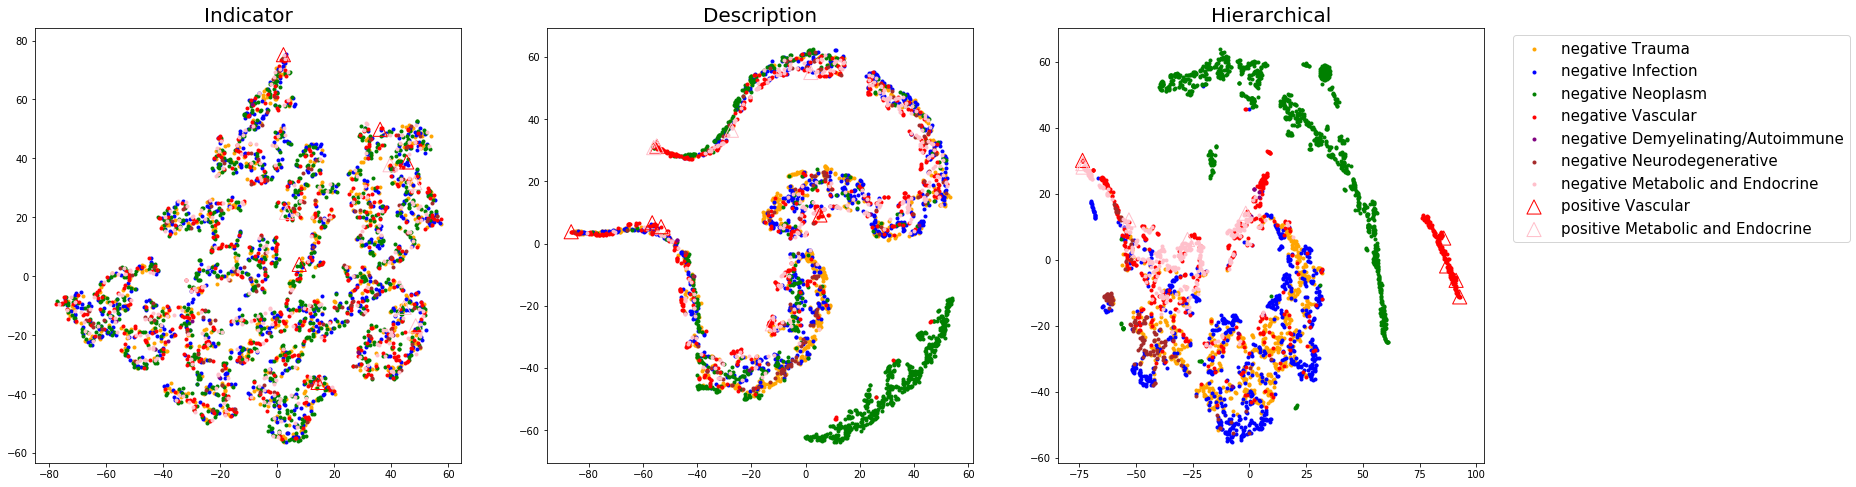

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(35, 8))
fittype = 'tsne'
ax[0].set_title('Indicator', fontsize=20)
graph_datapoint(ax[0], 3, 'code_supervision_unfrozen', 4000, fittype)
ax[1].set_title('Description', fontsize=20)
graph_datapoint(ax[1], 3, 'code_supervision_only_description_unfrozen', 4000, fittype)
ax[2].set_title('Hierarchical', fontsize=20)
graph_datapoint(ax[2], 3, 'code_supervision_only_linearization_description_unfrozen', 4000, fittype)
plt.legend(fontsize=15, bbox_to_anchor=(1.05, 1))
plt.subplots_adjust(right=0.7)
plt.savefig('context_vectors2.pdf')
plt.show()

fitting
fitting
fitting


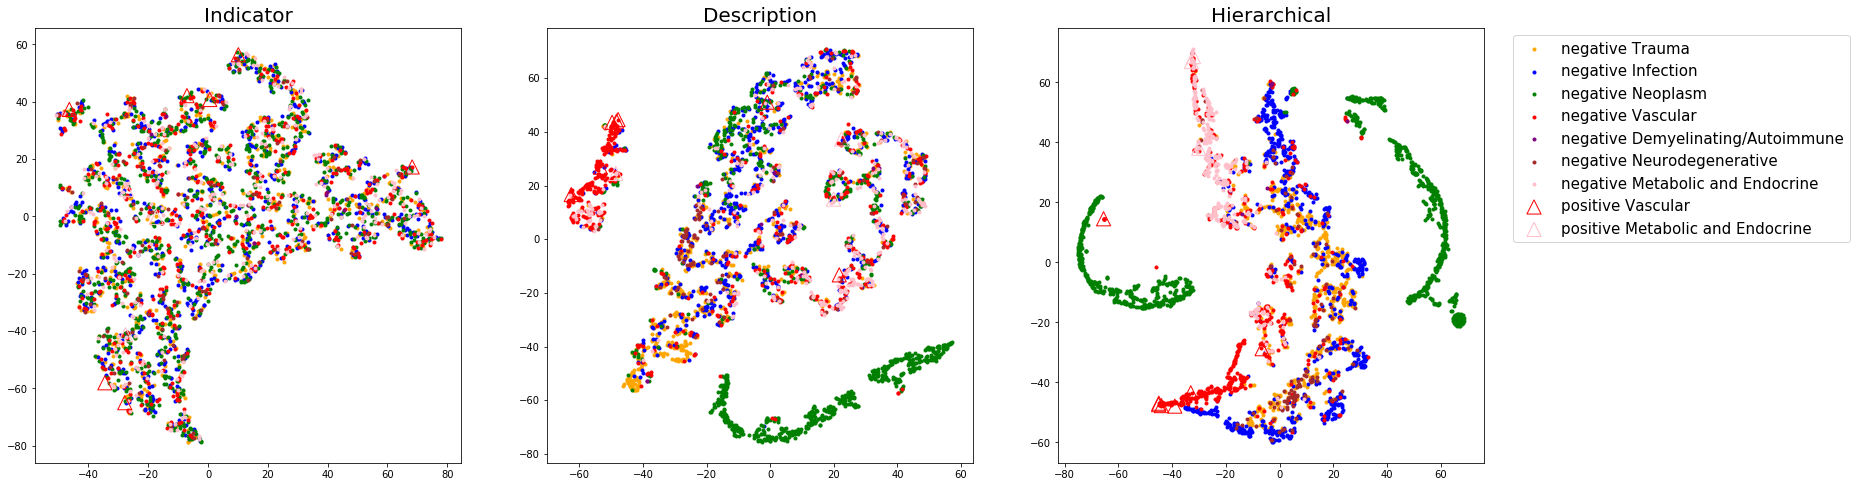

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(35, 8))
fittype = 'tsne'
ax[0].set_title('Indicator', fontsize=20)
graph_datapoint(ax[0], 4, 'code_supervision_unfrozen', 4000, fittype)
ax[1].set_title('Description', fontsize=20)
graph_datapoint(ax[1], 4, 'code_supervision_only_description_unfrozen', 4000, fittype)
ax[2].set_title('Hierarchical', fontsize=20)
graph_datapoint(ax[2], 4, 'code_supervision_only_linearization_description_unfrozen', 4000, fittype)
plt.legend(fontsize=15, bbox_to_anchor=(1.05, 1))
plt.subplots_adjust(right=0.7)
plt.savefig('context_vectors3.pdf')
plt.show()

fitting
fitting
fitting


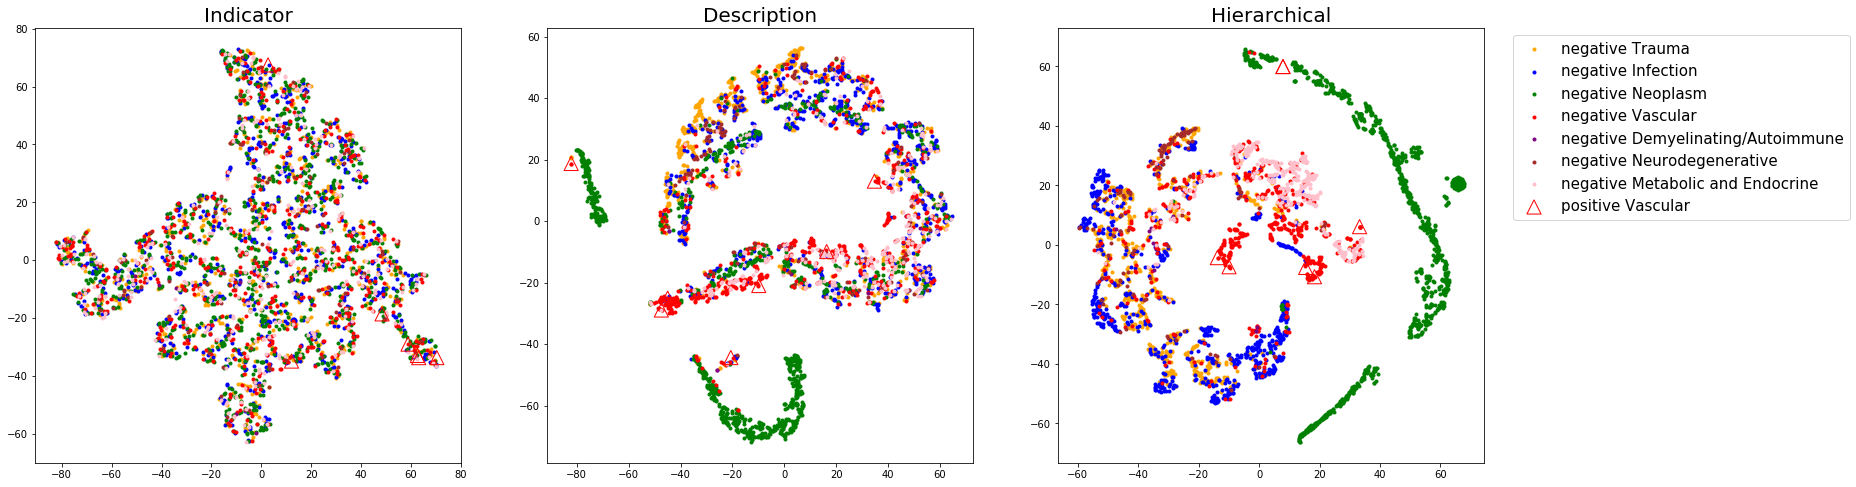

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(35, 8))
fittype = 'tsne'
ax[0].set_title('Indicator', fontsize=20)
graph_datapoint(ax[0], 5, 'code_supervision_unfrozen', 4000, fittype)
ax[1].set_title('Description', fontsize=20)
graph_datapoint(ax[1], 5, 'code_supervision_only_description_unfrozen', 4000, fittype)
ax[2].set_title('Hierarchical', fontsize=20)
graph_datapoint(ax[2], 5, 'code_supervision_only_linearization_description_unfrozen', 4000, fittype)
plt.legend(fontsize=15, bbox_to_anchor=(1.05, 1))
plt.subplots_adjust(right=0.7)
plt.savefig('context_vectors4.pdf')
plt.show()